In [ ]:
!pip install chromadb sentence-transformers langchain

In [2]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import os
import matplotlib.pyplot as plt
from langchain.tools import tool

##work on frames

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [4]:
folder_path = "/content/test_folder"

In [63]:
def search_images(folder_path, query , topk = 2) :
  image_files = [f for f in os.listdir(folder_path)
              if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

  if not image_files:
    print("empty file")
    return []

  images = [Image.open(os.path.join(folder_path, img_file)) for img_file in image_files]

  inputs = processor(text=query, images=images, return_tensors="pt", padding=True)
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image
  prob = logits_per_image
  results = list(zip(image_files, prob.tolist()))

  results.sort(key=lambda x: x[1], reverse=True)
  top_filenames = [filename for filename, _ in results[:topk]]

  for i , (filename , score) in  enumerate(results[:topk]):
    img = Image.open(os.path.join(folder_path, filename))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


  return top_filenames

#search in text "RAG"

###create simulate data

In [27]:
import json

In [47]:
TTs_data = [
{
  "language": "ar",
  "title": "مقدمة في تعلم الآلة",
  "duration": "00:02:00",
  "segments": [
    {
      "start": "00:00:00",
      "end": "00:00:20",
      "text": "مرحباً بكم في دورتنا لتعلم الآلة للمبتدئين. في هذه الدورة، سنتعرف على المفاهيم الأساسية لتعلم الآلة، وكيف يمكن للكمبيوتر أن يتعلم من البيانات بدلاً من البرمجة الصريحة."
    },
    {
      "start": "00:00:20",
      "end": "00:00:40",
      "text": "ما هو تعلم الآلة؟ ببساطة، هو فرع من الذكاء الاصطناعي يتيح للأنظمة أن تتعلم من البيانات وتتحسن مع مرور الوقت، دون أن تتم برمجتها بشكل مباشر لحل كل مشكلة."
    },
    {
      "start": "00:00:40",
      "end": "00:01:00",
      "text": "هناك ثلاثة أنواع رئيسية من تعلم الآلة: التعلم الخاضع للإشراف، التعلم غير الخاضع للإشراف، والتعلم المعزز. سنبدأ بالتعلم الخاضع للإشراف لأنه الأكثر شيوعاً وسهولة للفهم."
    },
    {
      "start": "00:01:00",
      "end": "00:01:20",
      "text": "في التعلم الخاضع للإشراف، نقوم بتدريب النموذج باستخدام بيانات تحتوي على مدخلات ومخرجات معروفة، مثل التنبؤ بدرجات الطلاب بناءً على عدد ساعات المذاكرة."
    },
    {
      "start": "00:01:20",
      "end": "00:01:40",
      "text": "أما في التعلم غير الخاضع للإشراف، لا تكون المخرجات معروفة، ونحاول اكتشاف الأنماط في البيانات، مثل تقسيم العملاء إلى مجموعات بناءً على سلوك الشراء."
    },
    {
      "start": "00:01:40",
      "end": "00:02:00",
      "text": "في نهاية هذه الدورة، ستكون لديك القدرة على فهم الأساسيات، وتصميم نماذج بسيطة باستخدام أدوات مثل بايثون وScikit-learn. فلنبدأ رحلتنا مع تعلم الآلة!"
    }
  ]
} # Added the missing closing curly brace here
]
with open("arabic_tts_dataset.json", "w", encoding="utf-8") as file:
    json.dump(TTs_data, file, ensure_ascii=False, indent=2)

print("Data saved to arabic_tts_dataset.json")

Data saved to arabic_tts_dataset.json


##start working on text

###imports

In [29]:
import google.generativeai as genai
import numpy as np
import datetime as dt
from langchain.text_splitter import RecursiveCharacterTextSplitter
import chromadb
from chromadb.utils import embedding_functions
import json

##set LLMs , open folders ,..

In [30]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key= GOOGLE_API_KEY)

In [31]:
llm = genai.GenerativeModel("gemini-2.0-flash")
embeddings = "paraphrase-multilingual-MiniLM-L12-v2"

In [48]:
with open('arabic_tts_dataset.json', 'r', encoding='utf-8') as f:
    segments = json.load(f)

##start the RAG

### vector chromaDB "https://docs.trychroma.com/docs/overview/introduction"

In [51]:
def split_text_into_chunks(segments):
  text_spilliter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=50,
    separators=["\n", "۔", "؟", "!", " ", ""]
  )
  chunks = []
  for segment in segments:
    text_chunks = text_spilliter.split_text(segment["text"])

    for chunk in text_chunks:
        chunks.append({
            "text": chunk,
            "start_time": segment["start"],
            "end_time": segment["end"]
        })

  return chunks

In [53]:
chunks = split_text_into_chunks(segments[0]["segments"])

In [54]:
def initializeDB(embeddings,chunks):
  client = chromadb.PersistentClient(path="/content/vector_db")
  embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
  model_name= embeddings
  )
  collection = client.create_collection(
    name="tts_collection1",
    embedding_function=embedding_func
  )

  collection.add(
    documents=[chunk["text"] for chunk in chunks],

    metadatas = [{
      "start_time": chunk["start_time"],
      "end_time": chunk["end_time"]
  } for chunk in chunks],

  ids=[str(i) for i in range(len(chunks))]
  )
  return collection

In [55]:
collection = initializeDB(embeddings,chunks)

In [56]:
def Retrive_similar(collection , query, top_k=2):
  results = collection.query(
      query_texts = query,
      n_results = top_k,
      include=["documents", "metadatas"]
  )
  return [
        {
            "text": doc,
            "start_time": meta["start_time"],
            "end_time": meta["end_time"]
        }
        for doc, meta in zip(results["documents"][0], results["metadatas"][0])
    ]

###Generate answer using LLM

In [57]:
def generate_Answer(collection , query):
  similar_chunks = Retrive_similar(collection , query)

  context = "\n\n".join(
        f"[{chunk['start_time']}-{chunk['end_time']}] {chunk['text']}"
        for chunk in similar_chunks
    )

  prompt = f"""
    استخدم المقاطع التالية فقط للإجابة.
    المقاطع:
    {context}

    السؤال: {query}

    المتطلبات:
    1. أجب بالعربية الفصحى فقط
    2. اذكر الأوقات بين [] إذا وجدت
    3. لا تختلق معلومات
    4. إجابة مختصرة (1-2 جمل)

    مثال:
    [00:01:00] يمكنك تفعيل الميزة من الإعدادات
    """
  response = llm.generate_content(prompt)
  return response.text

In [58]:
@tool
def answer_frames_rags(collection,query, folder_path , topk):
  """Answers questions by combining image and text search results.

  Args:
    collection: The ChromaDB collection for text search.
    query: The text query to use for searching.
    folder_path: The path to the folder containing images for image search.
    topk: The number of top image results to return.

  Returns:
    A tuple containing the image search results and the generated text answer.
  """
  prompt = f"""

  you are an expert in translation from Arabic to English
  translate that {query} only to English
  the translated data will send to clip model
  """
  response = llm.generate_content(prompt)
  image = search_images(folder_path , response.text , topk)
  text = generate_Answer(collection , response.text )
  print("Frame timestamp : " ,image)
  print("Answer : " , text)
  return image , text

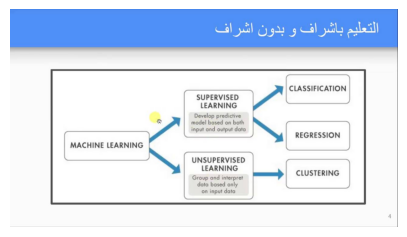

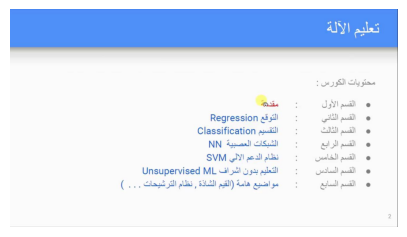

Frame timestamp :  ['keyframe_0002.jpg', 'keyframe_0001.jpg']
Answer :  التعلم الخاضع للإشراف هو تدريب النموذج باستخدام بيانات تحتوي على مدخلات ومخرجات معروفة [00:01:00-00:01:20]. وهو نوع رئيسي من تعلم الآلة [00:00:40-00:01:00].



In [64]:
image , text = answer_frames_rags.run({"collection": collection, "query": "ما هو التعليم باشراف ", "folder_path": folder_path, "topk": 2})
